# Terreno variable

Introducimos un valle. Esto provocará que la altitud del suelo con respecto al mar sea una función del terreno g(x,y).

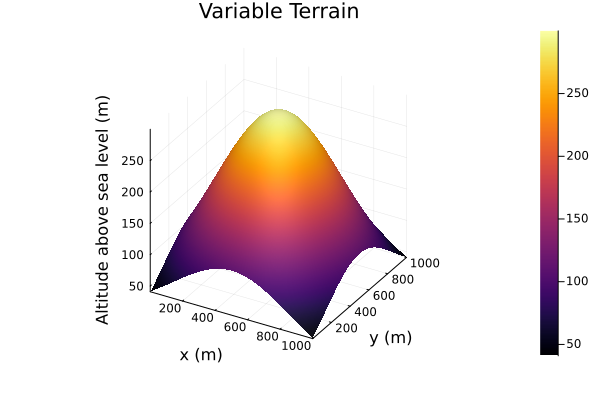

In [8]:
using Plots
# Definición de una función de terreno que simule una pequeña montaña de 300m de altitud. Escogemos una forma gaussiana
function g(x, y)
    return 300*exp(-(((x-501)/(501))^2 + ((y-501)/(501))^2))
end


# Creación de la malla de puntos (x,y)
x = range(1, stop=1001, length=1000)
y = range(1, stop=1001, length=1000)

# Cálculo de la altitud z en cada punto (x,y)
h_i = [g(xi, yi) for xi in x, yi in y]
plot()
# Visualización del terreno
surface(x, y, h_i, title="Variable Terrain", xlabel="x (m)", ylabel="y (m)", zlabel="Altitude above sea level (m)")


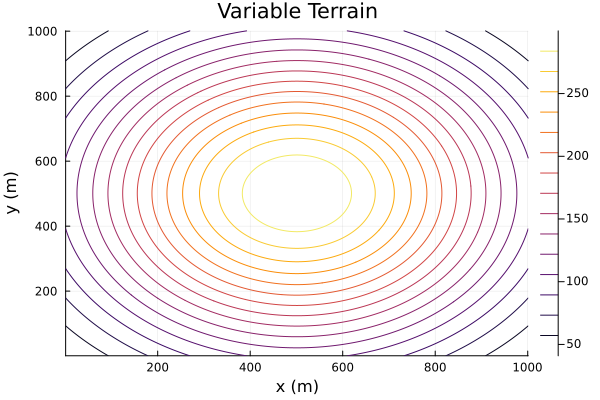

In [9]:
plot()
contour(x, y, h_i, title="Variable Terrain", xlabel="x (m)", ylabel="y (m)", zlabel="Altitude above sea level (m)")

In [10]:
#Obtenemos la temperatura a nivel de mar a partir de la temperatura medida en la fuente, cuya altitud es conocida,
#sabiendo que cae un grado centígrado cada 300m aproximadamente.
function c_air_TZ(T_source,g,x,y,h)
    elevation=g(x,y)
    if h<elevation
        z=0
    else
        z=h-elevation
    end
    c_air=331*sqrt((T_source+273.15-z/300)/273.15) #Introduzco T_Z0 en grados centígrados por comodidad
    return c_air
end

c_air_TZ (generic function with 1 method)

In [11]:
#Pedimos que el viento dependa de la altitud siguiendo 
function v_wind_LogLaw(v_wind,z_source,z)
    v_wind_X=v_wind[1]*log(z/z_source)
    v_wind_Y=v_wind[2]*log(z/z_source)
    return v_wind_X, v_wind_Y
end

v_wind_LogLaw (generic function with 1 method)

In [12]:
using DifferentialEquations
#Argumentos y datos
v_wind=[0.,10.];
T=20.
#Introducimos una fuente de 1m de altura a nivel de suelo, y un receptor de 1m de altura a 1km de altura sobre nivel de suelo.
h_s=1.
h_r=201.
SourcePoint=[1.,1.,g(1.,1.)+h_s];
ReceiverPoint=[1001.,1001.,g(1001.,1001.)+h_r];
println(SourcePoint)
println(ReceiverPoint)
#El modelo logarítmico de viento es razonable hasta altitudes no muy grandes.
function Hamiltonian(c_air_TZ, T_source::Float64,  v_wind::Array{Float64, 1}, g, SegmentsCoords::Array{Float64, 2})
    
   #Definimos la ODE 
    function q!(dq, q, p, z)
        c=c_air_TZ(p[1],g, SegmentsCoords[1,1], SegmentsCoords[1,2], SegmentsCoords[1,3])
        dq[1]=0
        dq[2]=0
        dq[3] = 331^2*sqrt(q[1]^2 + q[2]^2 + q[3]^2)*q[3] / (600 * 273.15 *c) - 10*q[2]*q[3]/z
    end
    theta=rad2deg(acos((200+g(1001.,1001.)-g(1.,1.))/(sqrt(2*1000^2+(200+g(1001.,1001.)-g(1.,1.))^2))))
    phi=45 #Calculados directamente
    # Definimos las condiciones iniciales y los parámetros
    q0=1/(c_air_TZ(T_source, g, SegmentsCoords[1,1], SegmentsCoords[1,2], SegmentsCoords[1,3])+(v_wind[1]*cosd(phi)+v_wind[2]*sind(phi))*sind(theta))
    q_x = q0*cosd(phi)*sind(theta)
    q_y = q0*sind(phi)*sind(theta)
    q_z = q0*cosd(theta)
    u0 = [q_x, q_y, q_z]

    # Definimos el rango de valores de z. Debemos tener cuidado al optimizar, dado
    # que si algún valor (coordenada z) optimizado está fuera de zspan no podemos evaluarlo.
    
    #La altitud máxima del receptor ha de ser de 1km
    zspan = (SegmentsCoords[1,3], 1001)

    # Definimos los parámetros
    p = [T_source]

    # Definir el problema ODE
    prob = ODEProblem(q!, u0, zspan, p)
    
    #Resolvemos el problema ODE almacenando en los valores de Z que se corresponden a las uniones de los segmentos.
    z_values=zeros(length(SegmentsCoords[:,3]))
    switch=1. #Caso en el cual no haya ningún valor de Z por debajo/a ras de la altitud del terreno.
    for i in 1:length(SegmentsCoords[:,3])
        elevation_i=g(SegmentsCoords[i,1],SegmentsCoords[i,2])
        if SegmentsCoords[i,3]<=elevation_i
            total_travel_time=1e9
            switch=0. #Caso en el cual haya algún valor de Z por debajo/a ras de la altitud del terreno.
            break
        else
            z_values[i]=SegmentsCoords[i,3]
        end
    end
    if switch==1.
        sol = solve(prob, RK4(), saveat=z_values)
        #Guardamos los valores de vec(q)
        qx_vals=zeros(length(sol.u))
        qy_vals=zeros(length(sol.u))
        qz_vals=zeros(length(sol.u))
        #Pedimos que el programa nos avise si hay problema con el tamaño de la solución.
        if length(sol.u) != size(SegmentsCoords, 1)
        println("Warning: Mismatch in sizes of sol.u and SegmentsCoords")
        else
            for i in 1:length(sol.u)
                qx_vals[i]=sol.u[i][1]
                qy_vals[i]=sol.u[i][2]
                qz_vals[i]=sol.u[i][3]
            end
        end
        #Calculamos los traveltime entre cada segmento tomando la media de las q entre cada segmento (aproximación regla Trapecio)
        taus=zeros(length(SegmentsCoords[:,1])-1)
        for i in 1:(length(SegmentsCoords[:,1])-1)
            qx_m=(qx_vals[i]+qx_vals[i+1])/2
            aux_x=(SegmentsCoords[i+1,1]-SegmentsCoords[i,1])
            qy_m=(qy_vals[i]+qy_vals[i+1])/2
            aux_y=(SegmentsCoords[i+1,2]-SegmentsCoords[i,2])
            qz_m=(qz_vals[i]+qz_vals[i+1])/2
            aux_z=(SegmentsCoords[i+1,3]-SegmentsCoords[i,3])
            q_m=sqrt(qx_m^2+qy_m^2+qz_m^2)
            taus[i]=q_m*sqrt(aux_x^2+aux_y^2+aux_z^2)
        end
        #Sumamos el travel time de cada segmento para obtener el total
        total_travel_time = sum(taus)
    end
              
    return total_travel_time
end

[1.0, 1.0, 41.92571272487799]
[1001.0, 1001.0, 241.925712724878]


Hamiltonian (generic function with 1 method)

In [13]:
@time begin
using Optim
using Statistics

#Optimizamos las coordenadas de las uniones entre segmentos
function objective(SegmentsCoords)
    # Primero nos aseguramos de que SourcePoint y ReceiverPoint no se optimicen pero que se incluyan en SegmentsCoords
    FullSegmentsCoords = vcat(reshape(SourcePoint, 1, :), SegmentsCoords, reshape(ReceiverPoint, 1, :))
    traveltime = Hamiltonian(c_air_TZ, T, v_wind, g, FullSegmentsCoords)

    # Calculamos las distancias entre segmentos consecutivos
    segment_distances = diff(FullSegmentsCoords, dims=1)

    # Calculamos la desviación estándar de las distancias
    distance_std_normalized = Statistics.std(segment_distances)/(ReceiverPoint[3]-SourcePoint[3])

    # Agregamos una penalización a la función objetivo basada en la desviación estándar de las distancias
    return traveltime + distance_std_normalized
end

#Condicion inicial
num_segments=16;
initial_SegmentsCoords = zeros(num_segments-1, 3); 
for i in 1:num_segments-1
    alpha = i / num_segments
    initial_SegmentsCoords[i, :] = SourcePoint + alpha * (ReceiverPoint - SourcePoint) 
    Diff_h=h_r-h_s
    initial_SegmentsCoords[i, 3] = g(initial_SegmentsCoords[i, 1],initial_SegmentsCoords[i, 2])+ h_s + alpha * Diff_h
end
# Tenemos que tomar restricciones "de caja" para que los valores de z (SegmentsCoords[:,3]) 
#optimizados no esten fuera del intervalo de solución (zspan)
lower_bounds = fill(SourcePoint[1], size(initial_SegmentsCoords))
upper_bounds = fill(ReceiverPoint[1], size(initial_SegmentsCoords))
lower_bounds[:,3] .= SourcePoint[3]
upper_bounds[:,3] .= 3001.

# Optimizador interno. Limited-memory Broyden-Fletcher-Goldfarb-Shanno
#método de optimización de segundo orden valido para minimizar funciones no lineales.
inner_optimizer = LBFGS()

# Optimizador con las restricciones "de caja"
optimizer_with_constraints = Fminbox(inner_optimizer)

# Optimizamos con las restricciones
result = optimize(objective, lower_bounds, upper_bounds, initial_SegmentsCoords, optimizer_with_constraints)

#Resultado de la optimización
Optimal_SegmentsCoords = result.minimizer;
    
#Incluimos la fuente y el receptor a las coordenadas optimizadas
Full_Optimal_SegmentsCoords= vcat(reshape(SourcePoint, 1, :), Optimal_SegmentsCoords, reshape(ReceiverPoint, 1, :))
    
#Evaluamos el traveltime para la trayectoria optimizada
traveltime = Hamiltonian(c_air_TZ, T, v_wind, g, Full_Optimal_SegmentsCoords) 
println("The total travel time for the segmented trajectory is: ", traveltime, " seconds")
println("Iteraciones realizadas: ", result.iterations)
println("Evaluaciones de la función: ", result.f_calls)
end


The total travel time for the segmented trajectory is: 4.249468141879335 seconds
Iteraciones realizadas: 31
Evaluaciones de la función: 2597
 24.736802 seconds (154.73 M allocations: 8.328 GiB, 7.83% gc time, 35.06% compilation time)


Tenemos que ver otra forma de iterar la condición inicial.

In [14]:
@time begin
using Optim
using Statistics
    
#Optimizamos las coordenadas de las uniones entre segmentos
function objective(SegmentsCoords)
    # Primero nos aseguramos de que SourcePoint y ReceiverPoint no se optimicen pero que se incluyan en SegmentsCoords
    FullSegmentsCoords = vcat(reshape(SourcePoint, 1, :), SegmentsCoords, reshape(ReceiverPoint, 1, :))
    traveltime = Hamiltonian(c_air_TZ, T, v_wind, g, FullSegmentsCoords)

    # Calculamos las distancias entre segmentos consecutivos
    segment_distances = diff(FullSegmentsCoords, dims=1)

    # Calculamos la desviación estándar de las distancias
    distance_std_normalized = Statistics.std(segment_distances)/(ReceiverPoint[1]-SourcePoint[1])

    # Agregamos una penalización a la función objetivo basada en la desviación estándar de las distancias
    return traveltime + distance_std_normalized
end

#Definimos una matriz de matrices Plot_Coords del tamaño del bucle para luego graficar la distancia de los puntos a una recta
Plot_Coords = Matrix{Matrix{Float64}}(undef, 7, 1)

#Iteramos la condición inicial
initial_SegmentsCoords = zeros(1, 3); #c.i.
for i in 1:5
    if i == 1
        initial_SegmentsCoords[1, :] = SourcePoint + (ReceiverPoint - SourcePoint) / 2
        initial_SegmentsCoords[1, 3] = g(initial_SegmentsCoords[1, 1],initial_SegmentsCoords[1, 2])+ (h_s + h_r)/2
    end
    lower_bounds = fill(SourcePoint[1], size(initial_SegmentsCoords))
    upper_bounds = fill(ReceiverPoint[1], size(initial_SegmentsCoords))
    lower_bounds[:,3] .= SourcePoint[3]
    upper_bounds[:,3] .= 3001.
    inner_optimizer = LBFGS()
    optimizer_with_constraints = Fminbox(inner_optimizer)
    result = optimize(objective, lower_bounds, upper_bounds, initial_SegmentsCoords, optimizer_with_constraints)
    Optimal_SegmentsCoords = result.minimizer;
    Full_Optimal_SegmentsCoords= vcat(reshape(SourcePoint, 1, :), Optimal_SegmentsCoords, reshape(ReceiverPoint, 1, :))
        
    #Almacenamos las coordenadas de la optimización incluyendo la fuente y el receptor para luego graficar
    Plot_Coords[i]=Full_Optimal_SegmentsCoords
    
    #Evaluamos el travel time para los distintos números de segmentos planteados
    total_time = Hamiltonian(c_air_TZ, T, v_wind, g, Full_Optimal_SegmentsCoords)
    println("Num segments: ", Int(size(Full_Optimal_SegmentsCoords, 1) - 1), ". Traveltime:", total_time, " s")
    println("Iteraciones realizadas: ", result.iterations, ". Evaluaciones de la función: ", result.f_calls)


    copy_Optimal_SegmentsCoords = zeros(2 * size(Optimal_SegmentsCoords, 1) + 1, 3)
    h_ground = g.(Optimal_SegmentsCoords[:, 1], Optimal_SegmentsCoords[:, 2])
    htoground = Optimal_SegmentsCoords[:, 3] .- h_ground
    # Calculamos copy_optimal_SegmentsCoords 
    for j in 1:2 * size(Optimal_SegmentsCoords, 1) + 1
        if j==1
            copy_Optimal_SegmentsCoords[j,:]=(SourcePoint+Optimal_SegmentsCoords[1,:])/2
            copy_Optimal_SegmentsCoords[j,3]=g(copy_Optimal_SegmentsCoords[j,1],copy_Optimal_SegmentsCoords[j,2])+(h_s+htoground[1])/2
        elseif j==2*size(Optimal_SegmentsCoords,1)+1
            copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[end,:]+ReceiverPoint)/2
            copy_Optimal_SegmentsCoords[j,3]=g(copy_Optimal_SegmentsCoords[j,1],copy_Optimal_SegmentsCoords[j,2])+(htoground[end]+h_r)/2
        else
            if iseven(j)
                copy_Optimal_SegmentsCoords[j,:]=Optimal_SegmentsCoords[Int(j/2),:]
            else
                copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[Int((j-1)/2),:]+Optimal_SegmentsCoords[Int((j+1)/2),:])/2
                copy_Optimal_SegmentsCoords[j,3]=g(copy_Optimal_SegmentsCoords[j,1],copy_Optimal_SegmentsCoords[j,2])+(htoground[Int((j-1)/2)]+htoground[Int((j+1)/2)])/2
            end
        end
    end

    #Aquí iteramos la condición inicial
    initial_SegmentsCoords = copy(copy_Optimal_SegmentsCoords)
end
end

Num segments: 2. Traveltime:4.162306238426626 s
Iteraciones realizadas: 2. Evaluaciones de la función: 207
Num segments: 4. Traveltime:4.167814911303877 s
Iteraciones realizadas: 2. Evaluaciones de la función: 151
Num segments: 8. Traveltime:4.192130924957146 s
Iteraciones realizadas: 6. Evaluaciones de la función: 519
Num segments: 16. Traveltime:4.198488916844295 s
Iteraciones realizadas: 6. Evaluaciones de la función: 523
Num segments: 32. Traveltime:4.200127202464837 s
Iteraciones realizadas: 6. Evaluaciones de la función: 489
 13.988558 seconds (136.72 M allocations: 7.210 GiB, 9.25% gc time, 3.28% compilation time: 25% of which was recompilation)


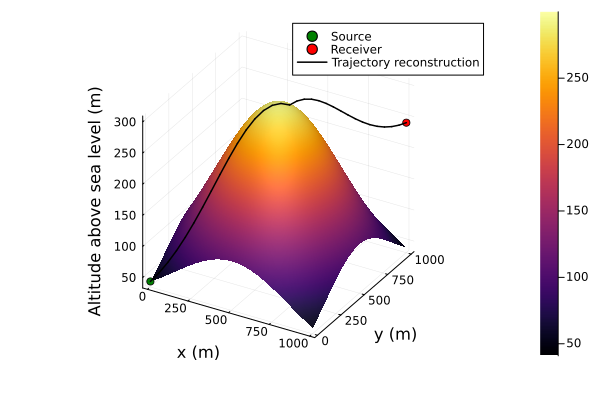

In [15]:
using Plots
# Definición de una función de terreno que simule una pequeña montaña de 300m de altitud. Escogemos una forma gaussiana
function g(x, y)
    return 300*exp(-(((x-501)/(501))^2 + ((y-501)/(501))^2))
end


# Creación de la malla de puntos (x,y)
x = range(1, stop=1001, length=1000)
y = range(1, stop=1001, length=1000)

# Cálculo de la altitud z en cada punto (x,y)
h_i = [g(xi, yi) for xi in x, yi in y]
# Visualización del terreno
p=surface(x, y, h_i, title="", xlabel="x (m)", ylabel="y (m)", zlabel="Altitude above sea level (m)",legend=:topright)
x_coords = Plot_Coords[5][2:end-1, 1]
y_coords = Plot_Coords[5][2:end-1, 2]
z_coords = Plot_Coords[5][2:end-1, 3]


#scatter!(x_coords, y_coords, z_coords, marker=:circle, color=:blue, label="Trajectory reconstruction")
scatter!([Plot_Coords[5][1, 1]], [Plot_Coords[5][1, 2]], [Plot_Coords[5][1, 3]], marker=:circle, color=:green, label="Source")
scatter!([Plot_Coords[5][end, 1]], [Plot_Coords[5][end, 2]], [Plot_Coords[5][end, 3]], marker=:circle, color=:red, label="Receiver")

for i in 1:size(Plot_Coords[5],1)-1
    if i == 1
        plot!(p, [Plot_Coords[5][i,1], Plot_Coords[5][i+1,1]], [Plot_Coords[5][i,2], Plot_Coords[5][i+1,2]],
            [Plot_Coords[5][i,3], Plot_Coords[5][i+1,3]], color=:black, linewidth=1.5, label="Trajectory reconstruction", legend=:topright)
    else
        plot!(p, [Plot_Coords[5][i,1], Plot_Coords[5][i+1,1]], [Plot_Coords[5][i,2], Plot_Coords[5][i+1,2]],
            [Plot_Coords[5][i,3], Plot_Coords[5][i+1,3]], color=:black, linewidth=1.5, label="")
    end
end
savefig(p,"EsquivaMonte_Trayectoria.png")
p

┌ Warning: Skipped marker arg circle.
└ @ Plots C:\Users\Miguel\.julia\packages\Plots\sxUvK\src\args.jl:1149
┌ Warning: Skipped marker arg circle.
└ @ Plots C:\Users\Miguel\.julia\packages\Plots\sxUvK\src\args.jl:1149
┌ Warning: Skipped marker arg circle.
└ @ Plots C:\Users\Miguel\.julia\packages\Plots\sxUvK\src\args.jl:1149
┌ Warning: Skipped marker arg circle.
└ @ Plots C:\Users\Miguel\.julia\packages\Plots\sxUvK\src\args.jl:1149
┌ Warning: Skipped marker arg circle.
└ @ Plots C:\Users\Miguel\.julia\packages\Plots\sxUvK\src\args.jl:1149
[ Info: Saved animation to C:\Users\Miguel\Desktop\TFM\Codigos Julia\CurveEvolutionVariableGround.gif


Plots.AnimatedGif("C:\\Users\\Miguel\\Desktop\\TFM\\Codigos Julia\\CurveEvolutionVariableGround.gif")
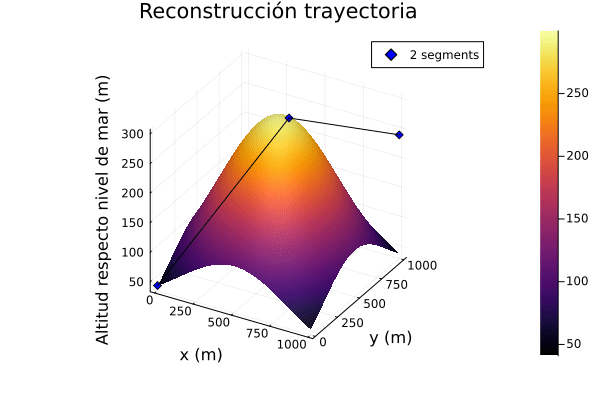

In [16]:
using Plots
using FFMPEG

# Definimos los nombres de las etiquetas y las formas para cada número de segmentos
labels = ["2 segments", "4 segments", "8 segments", "16 segments", "32 segments", "64 segments", "128 segments", "256 segments", "512 segments"]
shapes = [:diamond, :square, :star6, :octagon, :circle, :star4, :star5, :octagon, :circle]

# Creamos un array para almacenar cada cuadro del GIF
frames = []

# Iteramos sobre cada conjunto de coordenadas de segmentos
for i in 1:5
    p = surface(x, y, h_i, title="Terreno variable", xlabel="x (m)", ylabel="y (m)", zlabel="Altitud respecto nivel de mar (m)")

    x_coords = Plot_Coords[i][1:end, 1]
    y_coords = Plot_Coords[i][1:end, 2]
    z_coords = Plot_Coords[i][1:end, 3]

    scatter!(p, x_coords, y_coords, z_coords, marker=:circle, color=:blue, label=labels[i], shape=shapes[i], legend=:topright)
    for j in 1:size(Plot_Coords[i],1)-1
        plot!(p, [Plot_Coords[i][j,1], Plot_Coords[i][j+1,1]], [Plot_Coords[i][j,2], Plot_Coords[i][j+1,2]],
            [Plot_Coords[i][j,3], Plot_Coords[i][j+1,3]],color=:black, linewidth=1, label="")
    end
    title!("Reconstrucción trayectoria")
    push!(frames, p)
end

# Creamos el GIF a partir de los cuadros
anim = @animate for i=1:length(frames)
    plot(frames[i])
end

# Guardamos el GIF
gif(anim,"CurveEvolutionVariableGround.gif",fps=0.5)